In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import numpy as np

from spaceoracle.tools.data import load_example_slideseq, filter_adata
from spaceoracle.tools.network import GeneRegulatoryNetwork

In [3]:
slideseq_data = load_example_slideseq('../data/slideseq/')
slideseq_data

[('../data/slideseq/mLND5_1.h5ad',
  AnnData object with n_obs × n_vars = 50058 × 19041
      obs: 'cluster'
      obsm: 'X_spatial', 'spatial'),
 ('../data/slideseq/mLND5_2.h5ad',
  AnnData object with n_obs × n_vars = 41361 × 18972
      obs: 'cluster'
      obsm: 'X_spatial', 'spatial'),
 ('../data/slideseq/mLND3_2.h5ad',
  AnnData object with n_obs × n_vars = 30242 × 25343
      obs: 'cluster'
      obsm: 'X_spatial', 'spatial'),
 ('../data/slideseq/mLND3_1.h5ad',
  AnnData object with n_obs × n_vars = 39721 × 24649
      obs: 'cluster'
      uns: 'cluster_colors'
      obsm: 'X_spatial', 'spatial')]

In [4]:
adata = slideseq_data[3][1].copy()
adata = filter_adata(adata, min_counts=500)

In [5]:
grn = GeneRegulatoryNetwork()
target_gene = 'Cd74'

regulators = grn.get_regulators(adata, target_gene=target_gene)
regulators, len(regulators)

(['Atf3',
  'Bcl11a',
  'Ebf1',
  'Ebf3',
  'Egr2',
  'Gata1',
  'Gata2',
  'Mef2a',
  'Mef2c',
  'Pax5',
  'Pou2f2',
  'Prdm9',
  'Snai3',
  'Stat2',
  'Taf1',
  'Tal1'],
 16)

In [6]:
X = adata.to_df()[regulators]
X

,Atf3,Bcl11a,Ebf1,Ebf3,Egr2,Gata1,Gata2,Mef2a,Mef2c,Pax5,Pou2f2,Prdm9,Snai3,Stat2,Taf1,Tal1
AAAAATCGCGTCCA,0.0,0.0,0.643342,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
AAAACCTCACATTT,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.458739,0.0,0.0,0.000000,0.000000,0.0
AAAACGTGATCCTA,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.691110,0.000000,0.0
AAAACTATTTAAGG,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
AAAAGATGCTCAGC,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.512969,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGACAGAG,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.646273,0.0
TTTTTTCGCGGCTA,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
TTTTTTGGGCTGGT,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.423997,0.0,0.0,0.423997,0.000000,0.0
TTTTTTGTACGATT,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.857282,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [7]:
y = adata.to_df()[[target_gene]]
y

,Cd74
AAAAATCGCGTCCA,0.000000
AAAACCTCACATTT,0.772030
AAAACGTGATCCTA,1.095895
AAAACTATTTAAGG,0.000000
AAAAGATGCTCAGC,1.744014
...,...
TTTTTTCGACAGAG,0.000000
TTTTTTCGCGGCTA,0.000000
TTTTTTGGGCTGGT,0.000000
TTTTTTGTACGATT,1.860506


In [8]:
xy = adata.obsm['spatial']
xy

ArrayView([[-2583.5,  2490.7],
           [-3975.2,  2855.4],
           [-1578.6,  2046. ],
           ...,
           [-3547.4,  2483.1],
           [-2052.1,  2937.7],
           [-2025.5,  2342.3]])

In [9]:
cluster_labels = adata.obs['cluster']
cluster_labels = np.array(cluster_labels)

In [10]:
from spaceoracle.models.estimators import ViTEstimator
estimator = ViTEstimator()

In [ ]:
estimator.fit(
    X.values[:, :], 
    y.values[:], 
    xy[:, :], 
    labels = np.array(adata.obs['cluster'].values[:]),
    init_betas='ols', 
    max_epochs=100, 
    learning_rate=3e-3, 
    spatial_dim=128,
    mode = 'train_test',
)

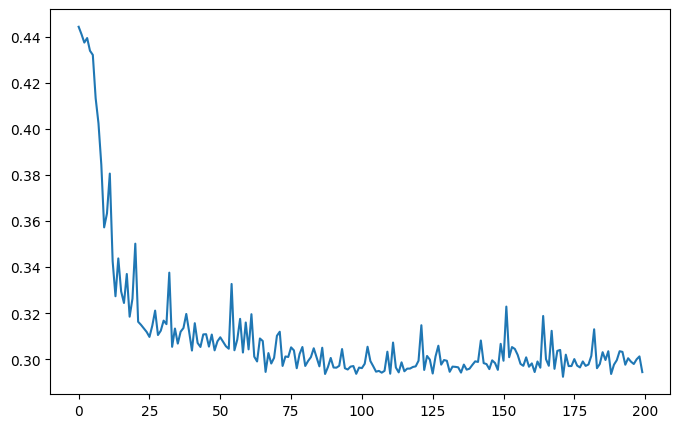

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses)
plt.show()

In [ ]:
betas, y_pred = estimator.get_betas(X.values[:, :], xy[:, :], cluster_labels[:], spatial_dim=128)

🌍️ Generating spatial maps: 100%|██████████| 9984/9984 [00:39<00:00, 252.42it/s]


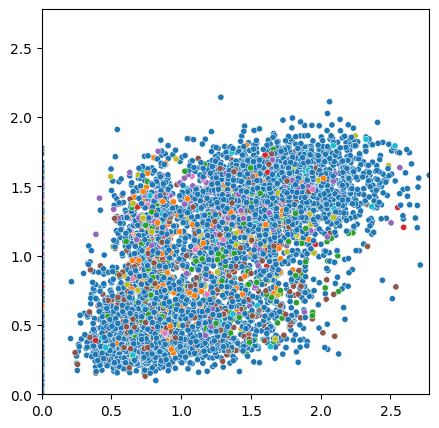

In [ ]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 100
sns.scatterplot(x=y.values[:, :].reshape(-1), y=y_pred.reshape(-1), s=20, c=adata.obs.cluster.values[:], cmap='tab10')
plt.xlim(y.values[:, :].min(), y.values[:, :].max())
plt.ylim(y.values[:, :].min(), y.values[:, :].max())
plt.show()

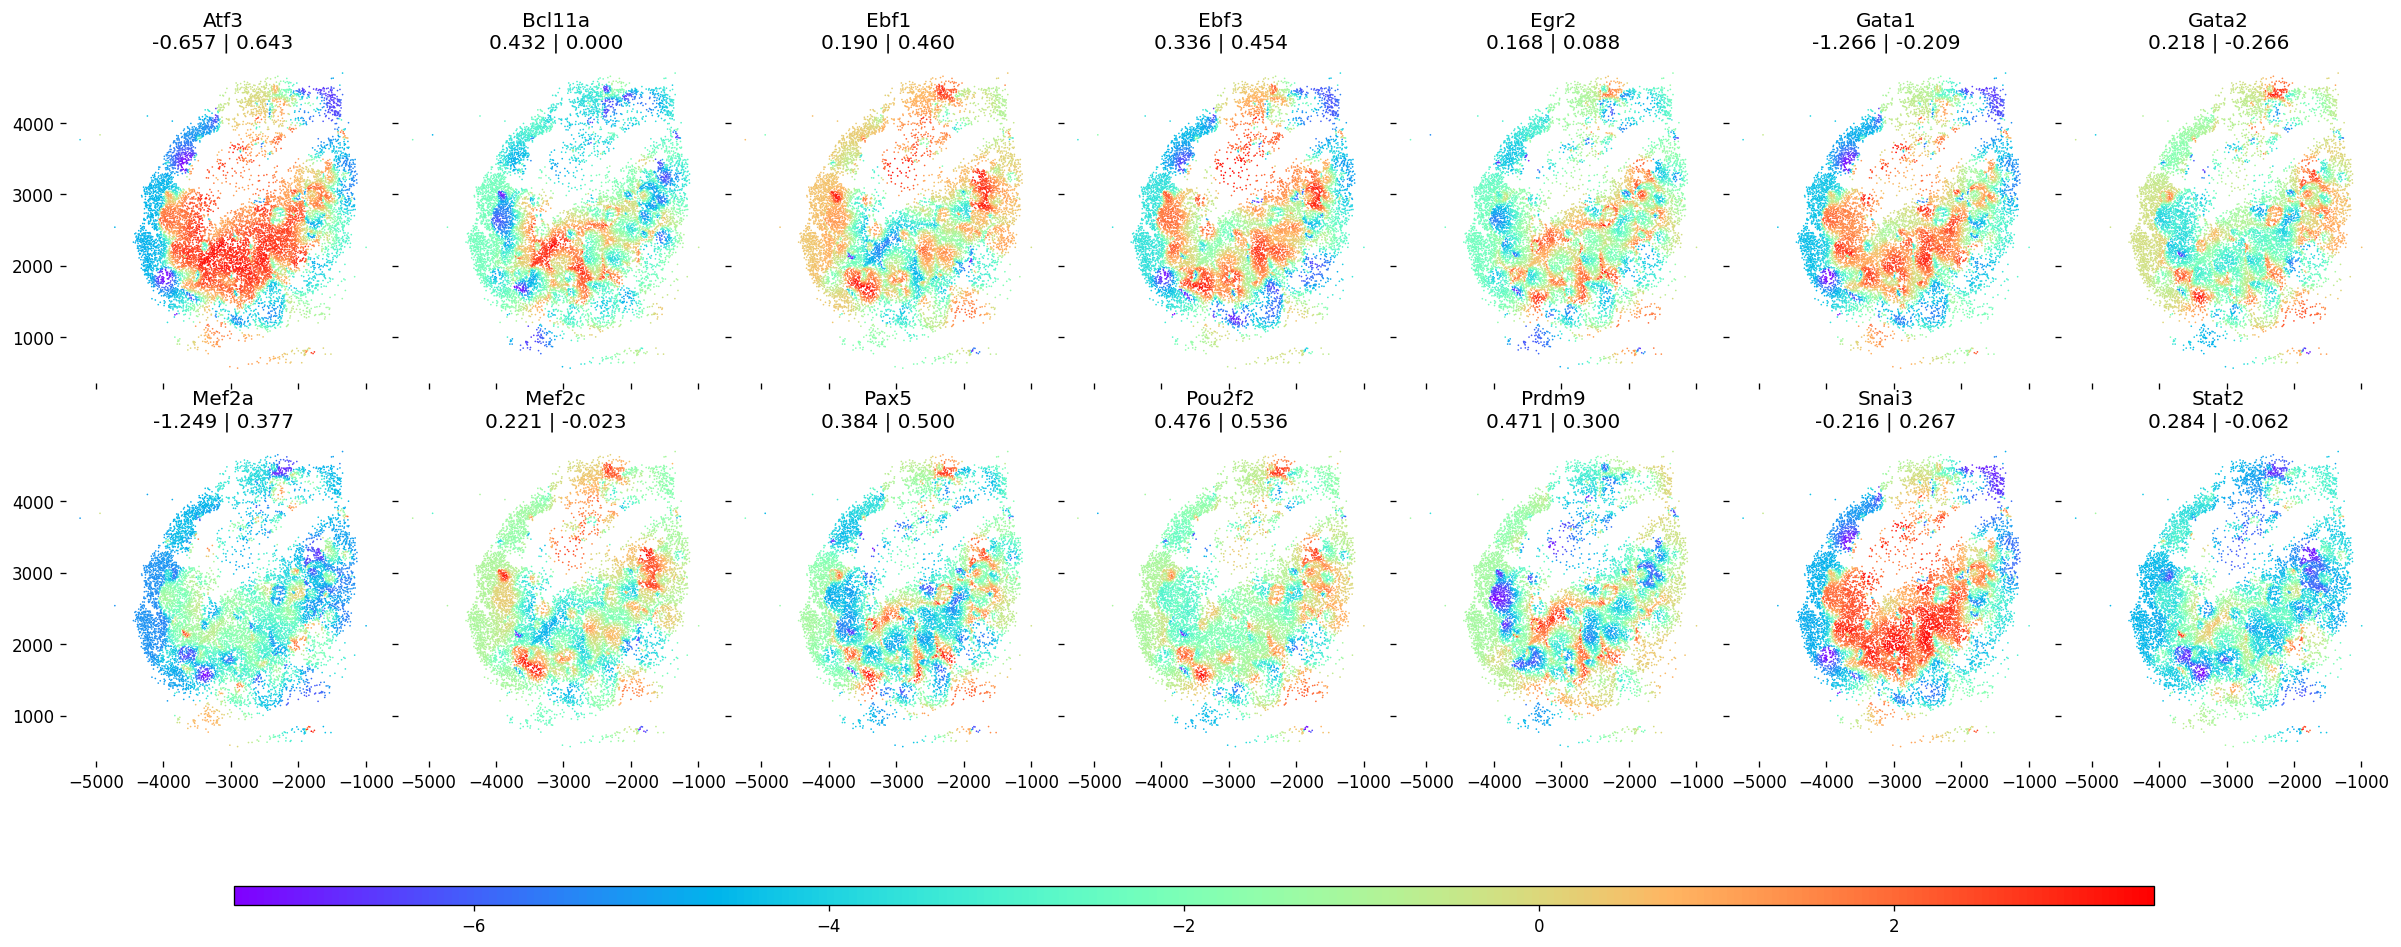

In [ ]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=120, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata.obsm['spatial'][:, 0], y=adata.obsm['spatial'][:, 1], 
                s=1, c=betas[:, i+1], cmap='rainbow', ax=axs[i], edgecolor=None, linewidth=0)
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{regulators[ix]}\n{beta_means[ix+1]:.3f} | {estimator.beta_init[ix]:.3f}')

# Adjust the layout to make space for the colorbar
plt.tight_layout()
f.subplots_adjust(bottom=0.2)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')

plt.show()

In [12]:
from spaceoracle.callbacks.simulation_callback import SimulationBetaCallback
from spaceoracle.callbacks.fixtures.simulator import SimulatedData

In [13]:
SimulatedData.X.shape

(4096, 2)

In [40]:
estimator.fit(
    SimulatedData.X, 
    SimulatedData.y, 
    SimulatedData.xy, 
    labels = SimulatedData.clusters,
    max_epochs=10, 
    learning_rate=3e-3, 
    spatial_dim=8,
    mode = 'train',
    n_patches=2, n_heads=4
)

🌍️ Generating spatial maps: 100%|██████████| 4096/4096 [00:00<00:00, 47558.97it/s]
[cuda] MSE: 0.0744 | Baseline: 0.4639: 100%|██████████| 10/10 [01:51<00:00, 11.14s/it]


In [41]:
check_betas = SimulationBetaCallback()
est_betas = estimator.get_betas(
        SimulatedData.X, 
        SimulatedData.xy, 
        SimulatedData.clusters,
        spatial_dim=8
    )[0]

check_betas(
    est_betas
)

🌍️ Generating spatial maps: 100%|██████████| 4096/4096 [00:00<00:00, 47898.82it/s]


{'beta0': 0.969708716332791,
 'beta1': 0.9077215807949174,
 'beta2': 0.856756611436146}

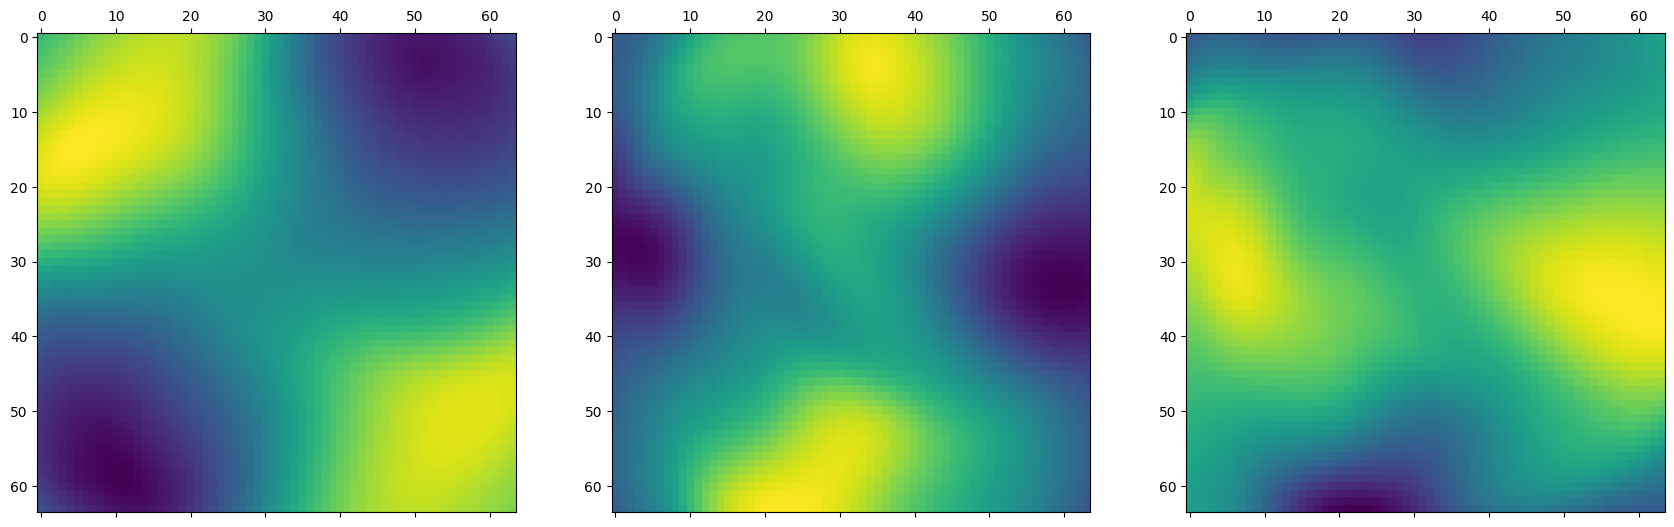

In [44]:
f, axs = plt.subplots(1, 3, figsize=(21, 7), dpi=100)
axs[0].matshow(est_betas[:, 0].reshape(64, 64))
axs[1].matshow(est_betas[:, 1].reshape(64, 64))
axs[2].matshow(est_betas[:, 2].reshape(64, 64))
plt.show()

In [42]:
# Examine attention weights

train_dataloader, valid_dataloader = estimator._build_dataloaders(
    X.values[:, :], 
    y.values[:], 
    xy[:, :], 
    labels= np.array(adata.obs['cluster'].values[:]),
    spatial_dim=128, 
    mode='train')

for batch_spatial, batch_x, batch_y, batch_labels in train_dataloader:
    break

🌍️ Generating spatial maps: 100%|██████████| 9984/9984 [00:39<00:00, 250.18it/s]


In [ ]:
y_pred, x, att_weights = estimator.model.get_att_weights(
    batch_spatial.to('cuda'), 
    batch_x.to('cuda'), 
    batch_labels.to('cuda'))

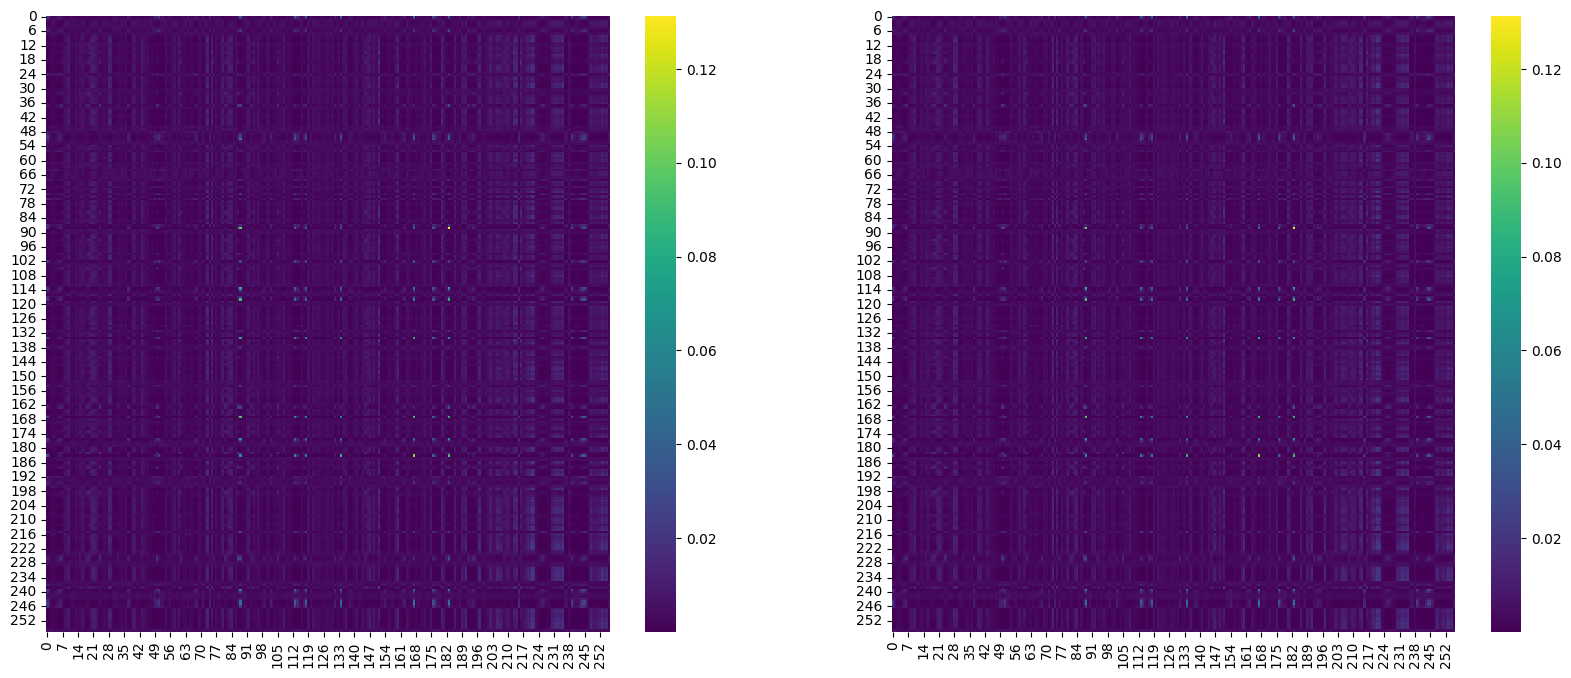

In [ ]:
import seaborn as sns

# att_weights is (2 n_blocks, 32 batch, 2 n_heads, 257 sequences (1x16), 257 sequences)

n_blocks = estimator.model.n_blocks
fig, axs = plt.subplots(ncols=n_blocks, figsize=(20, 8))

for i in range(n_blocks):
    sns.heatmap(att_weights[0][1][0].cpu().detach().numpy(), ax=axs[i], cmap='viridis')